## The Euro Problem

A Euro was spun 250 times, it landed heads 140 times and tails 110 times. Do these data give evidence that the coin is biased?

Two steps:
* Estimate the probability that the coin lands face up.
* Evaluate whether data support hypothesis that coin is biased.

Probability of coin landing face up can be written as x

Normally, we would expect x to be close to .5 but mught be different for a biased coin.

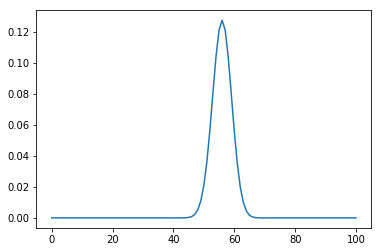

In [40]:
from thinkbayes import Pmf, Suite, Percentile, CredibleInterval
import matplotlib.pyplot as plt
import thinkbayes as thinkbayes


class Euro(Suite):
    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':
            return x/100.0
        else:
            return 1 - (x/100.0)
        
    def AddPlot(self, label):
        values = []
        probs = []
        for val, prob in self.Items():
            values.append(val)
            probs.append(prob)
        plt.plot(values, probs, label=label)
        
suite = Euro(range(0,101))
dataset = 'H' * 140 + 'T' * 110

for data in dataset: 
    suite.Update(data)

    
# suite.Items()
suite.AddPlot('uniform prior')
plt.show()


## Summarising the posterior

Several ways to summarise the posterior. 

We can find the most likely value in the distribution (the maximum likelihood).

We can also get the mean and median of the distribution, as well as the credible interval (90% CI).

In [33]:
class Euro(Suite):
    def Likelihood(self, data, hypo):
        x = hypo
        if data == 'H':
            return x/100.0
        else:
            return 1 - (x/100.0)
        
    def AddPlot(self, label):
        values = []
        probs = []
        for val, prob in self.Items():
            values.append(val)
            probs.append(prob)
        plt.plot(values, probs, label=label)

    def MaximumLikelihood(self):

        prob, val = max((prob, val) for val, prob in self.Items())
        return val
    
suite = Euro(range(0,101))
dataset = 'H' * 140 + 'T' * 110

for data in dataset: 
    suite.Update(data)
    
print('ML: ', suite.MaximumLikelihood())
print('Mean: ', suite.Mean())
print('Median: ', Percentile(suite, 50))
print('CI: ', CredibleInterval(suite, 90))

## Meaningless to get the probability at 50 exactly, number of hypos was arbitrary and effects this. CI is more useful for our question.
print('Prob(50): ', suite.Prob(50))

ML:  56
Mean:  55.952380952380956
Median:  56
CI:  (51, 61)
Prob(50):  0.02097652612954468


## Swamping the priors

What if we used a non uniform prior. Seems unlikely that a coin would be 100% biased to heads or tails.

We can do this with a triangular prior. When we then add the data, we see that the posterior is nearly identical. This shows that a lot of data can reduce differences in priors to being relatively negligible. This is referred to as 'swamping the prior'.


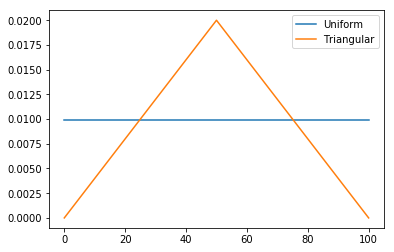

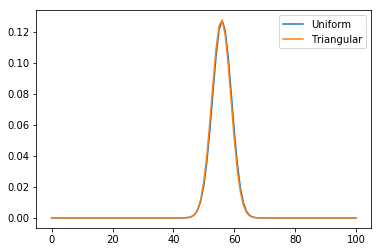

In [38]:
def TriangularPrior(plot=False, dataset=[]):
    suite = Euro()
    for x in range(0, 51):
        suite.Set(x, x)
    for x in range(51, 101):
        suite.Set(x, 100-x)
    suite.Normalize()
    if dataset:
        for data in dataset: 
            suite.Update(data)
    if plot:
        suite.AddPlot('Triangular')

        
        
suite = Euro(range(0,101))
suite.AddPlot('Uniform')
    
TriangularPrior(plot=True)
plt.legend()
plt.show()

dataset = 'H' * 140 + 'T' * 110

suite = Euro(range(0,101))
for data in dataset: 
    suite.Update(data)
suite.AddPlot('Uniform')
    
TriangularPrior(plot=True, dataset=dataset)
plt.legend()
plt.show()




## Optimization

The code used here is readable but not very efficient. We can improve it by not calling Normalise multiple times and instead writing a function to update a set of data.

We can also improve the likelihood function by passing in the total number of heads and tales and calculating it from that.



In [39]:
def UpdateSet(self, dataset):
    for data in dataset:
        for hypo in self.Values():
            like = self.Likelihood(data, hypo)
            self.Mult(hypo, like)
    return self.Normalize()

def Likelihood(self, data, hypo):
    x = hypo / 100.0
    heads, tails = data
    like = x**heads * (1-x)**tails
    return like

## Beta distribution

We have been using probability mass function to represent discrete set of values for x.

We can use a continuous distribution instead to improve efficiency.

Beta distribution: http://varianceexplained.org/statistics/beta_distribution_and_baseball/

https://stats.stackexchange.com/questions/47771/what-is-the-intuition-behind-beta-distribution

We can think of it as a probability distribution of probabilities.

Alpha and beta parameters can be thought of as 'heads' and 'tails' or 'hits' and 'misses' (or any other set of binomial outcomes).

Mean of distribution is alpha / alpha + beta.

Beta distribution is defined across interval from 0 to 1.

If you do a Bayesian update with a binomial likelihood function, the beta distribution is a conjugate prior. This means that if prior for x is a beta distribution then the posterior is also a beta distribution. When we update a prior beta with params alpha and beta (using heads/tails), then the posterior is a beta dist with params alpha+heads and beta+tails.

In [41]:
class Beta(object):
    def __init__(self, alpha=1, beta=1):
        self.alpha = alpha
        self.beta = beta
        
    def Update(self, data):
        heads, tails = data
        self.alpha += heads
        self.beta += tails
        
    def Mean(self):
        return float(self.alpha) / (self.alpha + self.beta)
    
    def EvalPdf(self, x):
        # This evaluates the pdf of the beta dist
        return x**(self.alpha-1) * (1-x)**(self.beta-1)
        
        
beta = thinkbayes.Beta()
beta.Update((140, 110))
print(beta.Mean())

0.5595238095238095


Cromwell's rule: you should avoid giving a prior probability of 0 to any hypothesis that is even remotely true (as it will remain 0 even with contradictory evidence)